In [75]:
# loading libraries for data manipulation
import numpy as np
import pandas as pd

# loading libraries for data visualization
import matplotlib.pyplot as plt
from plotnine import *
from PIL import Image

# import tensorflow and keras packages
import tensorflow as tf
from tensorflow import keras

# import helper functions
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

Recurrent Neural Networks take into account the temporal relationships in sequential data. While we can handle sequential data using densely connected feed forward or 1-D convolutional architectures, they don't often work as well as recurrent architectures which are specifically built for sequential data. 

Recurrent Neural Networks use cells which take in an input (such as a word, or a stock price) and generate an output, just like a node in a feed forward neural network. However, unlike a feed forward neural network, recurrent cells also take in the output of the cell at the previous time step. We call this output the hidden state.

Even though RNNs only have a single cell, we are feeding values through it over and over, as if it is a deep network. 

Preparing time-series data for an RNN needs more finessing than the dataset used for Feed Forward or Convolutional Neural Networks. 

Suppose you have 20 readings in a sequence (suppose it is the temperature per hour). In order to train the RNN to predict the temperature, I need to take the long sequence and break it into bite sized chunks. Suppose we want to train our model on the past 5 temperature readings and predict the current temperature. 

To do so, we will need to break the sequence of 20 readings into smaller sequences, each with 5 readings as input, and 1 reading as the output. 

#### Sunspots Data

We will utilize the sunspots data which looks at the average number of sunspots per month. 

In [76]:
sun_df = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv")
print(sun_df.shape)
sun_df.head()


(2820, 2)


,Month,Sunspots
0,1749-01,58.0
1,1749-02,62.6
2,1749-03,70.0
3,1749-04,55.7
4,1749-05,85.0


Our task will be to predict the average number of sunspots. 

In [77]:
# let's first extract the readings as an array, we will also record the time step of each reading
series = sun_df["Sunspots"].values.astype(np.float32).reshape(-1, 1)
time = np.arange(len(series))
print(series)
print(time)

[[58. ]
 [62.6]
 [70. ]
 ...
 [55.8]
 [33.3]
 [33.4]]
[   0    1    2 ... 2817 2818 2819]


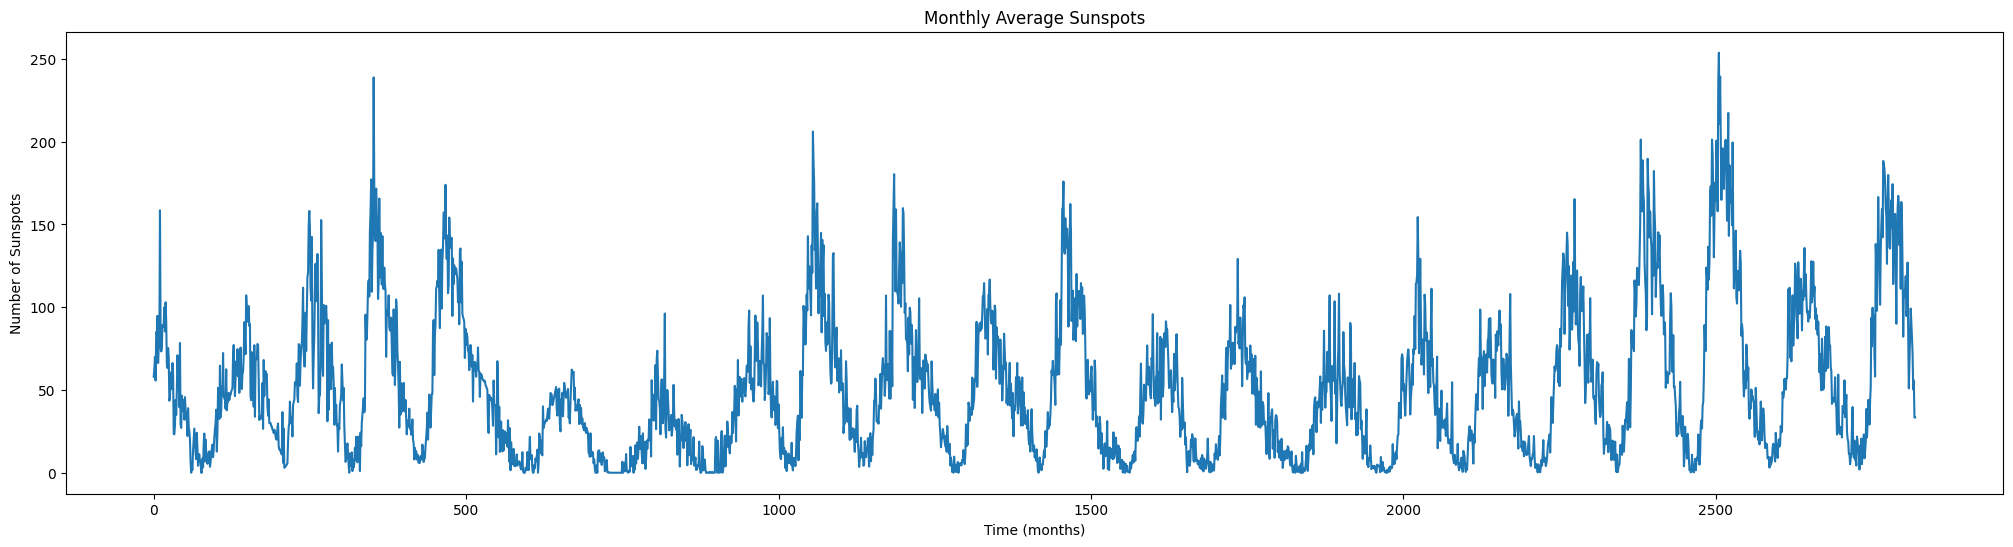

In [78]:
# Plot the data to visualize
plt.figure(figsize=(25, 6))
plt.plot(time, series)
plt.title("Monthly Average Sunspots")
plt.xlabel("Time (months)")
plt.ylabel("Number of Sunspots")
plt.show()

We will normalize the readings to help the network training

In [79]:
scaler = MinMaxScaler()
series = scaler.fit_transform(series)

We then split the data into training and validation set. Note here that there is no shuffling happening - we want the sequence to be maintained. If using an 80/20 for a train/validation split, then the latest 20% of the data will be used for the validation set. 

In [80]:
split_time = int(len(series) * 0.8)
X_train = series[:split_time]
X_valid = series[split_time:]

Similar to the Image Generator that keras provides for easily processing image inputs, we will utilize the Time Series Data Generator function to curate our sequential data. Here we can specify the window size (how long the sequence is), what the target at each time step is, and how to slide the window across time. 

In [59]:
# define the input window size - the number of time steps
window_size = 30 # we will use 30 readings at a time to predict the reading right after

# define the number of samples per batch
batch_size = 32 # how many input windows to process before calculating loss

# create the training dataset
train_ds = keras.utils.timeseries_dataset_from_array(
    data = X_train[:-1], # input data (exclude last point to make windows fit the large sequence)
    targets = X_train[window_size:], # target = next value after each window
    sequence_length = window_size, # how long each input window is
    sequence_stride = 1, # shift the window by 1 each time
    shuffle = True, # shuffles the order of input windows being processed (not the values within them!)
    batch_size = batch_size # number of sequences per batch
)

# create the validation dataset
valid_ds = keras.utils.timeseries_dataset_from_array(
    data = X_valid[:-1], 
    targets = X_valid[window_size:],
    sequence_length = window_size,
    sequence_stride = 1, 
    shuffle = False, 
    batch_size = batch_size
)


Let's train a simple RNN with one recurring layer. 

In [ ]:
simple_model = keras.Sequential([
    keras.layers.SimpleRNN(40,input_shape=[window_size,1],return_sequences=), # recurrent layer with 40 cells
    keras.layers.SimpleRNN(40,input_shape=[window_size,1]),
    keras.layers.Dense(1) # output layer - predicting 1 value
])

In [83]:
simple_model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)
)

In [ ]:
history = simple_model.fit(train_ds, epochs=20, validation_data=valid_ds)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0054 - val_loss: 0.0063
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036 - val_loss: 0.0050
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035 - val_loss: 0.0057
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033 - val_loss: 0.0049
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033 - val_loss: 0.0048
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034 - val_loss: 0.0049
Epoch 9/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033 - val_loss: 0.0052
Epoch 10/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034 - val_loss: 0.0049
Epoch 11/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033 - val_loss: 0.0049
Epoch 12/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034 - val_lo

 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


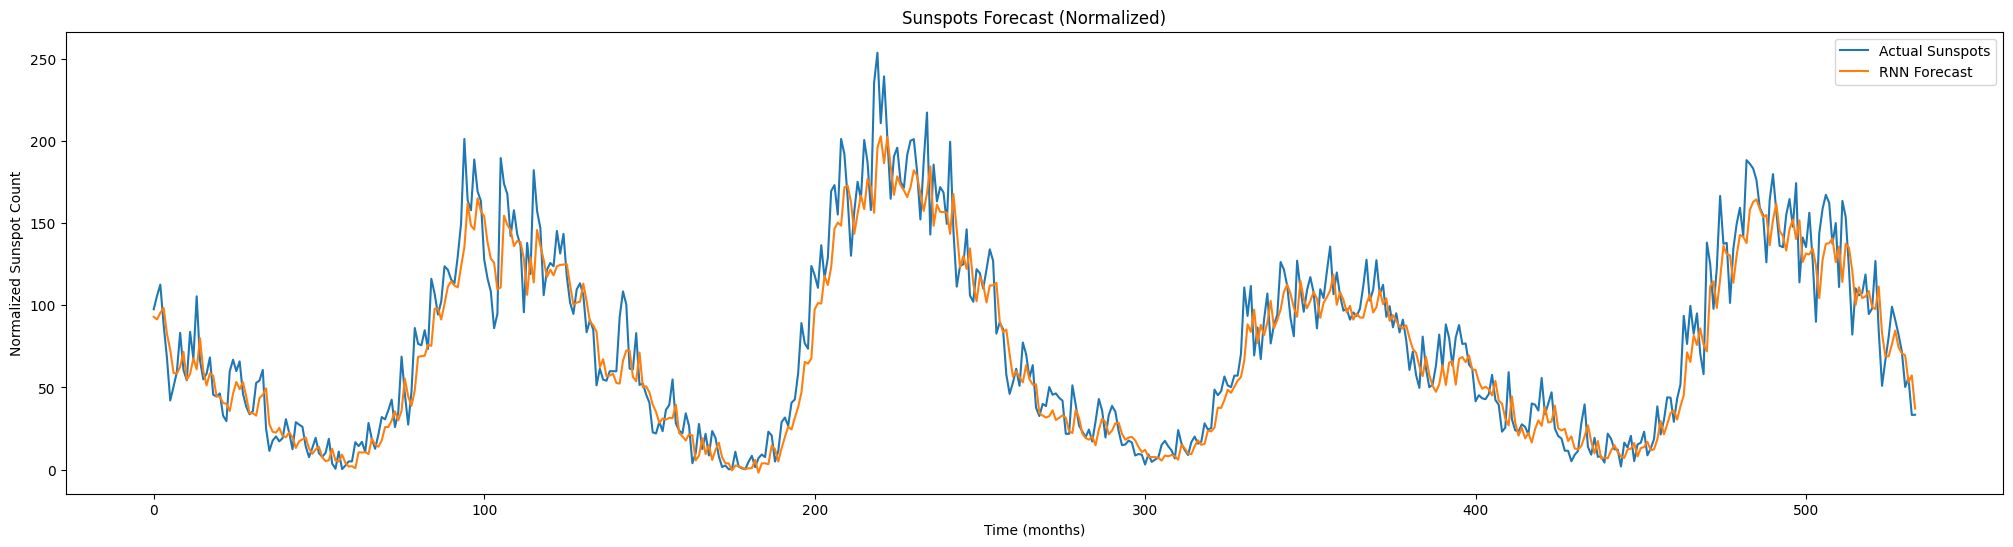

In [86]:
pred = simple_model.predict(valid_ds).flatten().reshape(-1, 1) # note that predictions are scaled!
pred_rescaled = scaler.inverse_transform(pred)

valid_rescaled = scaler.inverse_transform(X_valid[window_size:]).reshape(-1, 1)

# Plot actual vs predicted sunspot values
plt.figure(figsize=(25, 6))
plt.plot(valid_rescaled, label="Actual Sunspots")
plt.plot(pred_rescaled, label="RNN Forecast")
plt.title("Sunspots Forecast (Normalized)")
plt.xlabel("Time (months)")
plt.ylabel("Normalized Sunspot Count")
plt.legend()
plt.show()